In [62]:
import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

import warnings
warnings.filterwarnings('ignore')

# shares normalization factor
# 100 shares per trade
HMAX_NORMALIZE = 100
# initial amount of money we have in our account
INITIAL_ACCOUNT_BALANCE = 1000000
# total number of stocks in our portfolio
STOCK_DIM = 30
# transaction fee: 1/1000 reasonable percentage
TRANSACTION_FEE_PERCENT = 0.001

# turbulence index: 90-150 reasonable threshold
# TURBULENCE_THRESHOLD = 140
REWARD_SCALING = 1e-4

class StockEnvTrade(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self, df, day=0, turbulence_threshold=140, initial=True, previous_state=None, model_name='', iteration=''):
        self.day = day
        self.df = df
        self.initial = initial
        self.previous_state = previous_state if previous_state is not None else [INITIAL_ACCOUNT_BALANCE] + [0] * (STOCK_DIM * 2)
        self.action_space = spaces.Box(low=-1, high=1, shape=(STOCK_DIM,))
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(181,))
        self.data = self.df.loc[self.day,:]
        self.terminal = False
        self.turbulence_threshold = turbulence_threshold
        self.state = [INITIAL_ACCOUNT_BALANCE] + self.data.adjcp.values.tolist() + [0]*STOCK_DIM + self.data.macd.values.tolist() + self.data.rsi.values.tolist() + self.data.cci.values.tolist() + self.data.adx.values.tolist()
        self.reward = 0
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.asset_memory = [INITIAL_ACCOUNT_BALANCE]
        self.rewards_memory = []
        self.model_name = model_name
        self.iteration = iteration
        self._seed()

    def _sell_stock(self, index, action):
        if self.turbulence < self.turbulence_threshold:
            if self.state[index+STOCK_DIM+1] > 0:
                self.state[0] += self.state[index+1]*min(abs(action), self.state[index+STOCK_DIM+1]) * (1 - TRANSACTION_FEE_PERCENT)
                self.state[index+STOCK_DIM+1] -= min(abs(action), self.state[index+STOCK_DIM+1])
                self.cost += self.state[index+1]*min(abs(action), self.state[index+STOCK_DIM+1]) * TRANSACTION_FEE_PERCENT
                self.trades += 1
        else:
            if self.state[index+STOCK_DIM+1] > 0:
                self.state[0] += self.state[index+1]*self.state[index+STOCK_DIM+1]* (1 - TRANSACTION_FEE_PERCENT)
                self.state[index+STOCK_DIM+1] = 0
                self.cost += self.state[index+1]*self.state[index+STOCK_DIM+1]* TRANSACTION_FEE_PERCENT
                self.trades += 1
    
    def _buy_stock(self, index, action):
        if self.turbulence < self.turbulence_threshold:
            available_amount = self.state[0] // self.state[index+1]
            self.state[0] -= self.state[index+1]*min(available_amount, action)* (1 + TRANSACTION_FEE_PERCENT)
            self.state[index+STOCK_DIM+1] += min(available_amount, action)
            self.cost += self.state[index+1]*min(available_amount, action)* TRANSACTION_FEE_PERCENT
            self.trades += 1
    
    def step(self, actions):
        self.terminal = self.day >= len(self.df.index.unique()) - 1
        if self.terminal:
            plt.plot(self.asset_memory, 'r')
            plt.savefig('/kaggle/working/account_value_trade_{}_{}.png'.format(self.model_name, self.iteration))
            plt.close()
            df_total_value = pd.DataFrame(self.asset_memory)
            df_total_value.to_csv('/kaggle/working/account_value_trade_{}_{}.csv'.format(self.model_name, self.iteration))
            end_total_asset = self.state[0] + sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            print("previous_total_asset:{}".format(self.asset_memory[0]))
            print("end_total_asset:{}".format(end_total_asset))
            print("total_reward:{}".format(end_total_asset - self.asset_memory[0]))
            print("total_cost: ", self.cost)
            print("total trades: ", self.trades)
            df_total_value.columns = ['account_value']
            df_total_value['daily_return'] = df_total_value.pct_change(1)
            sharpe = (4**0.5)*df_total_value['daily_return'].mean() / df_total_value['daily_return'].std()
            print("Sharpe: ", sharpe)
            df_rewards = pd.DataFrame(self.rewards_memory)
            df_rewards.to_csv('/kaggle/working/account_rewards_trade_{}_{}.csv'.format(self.model_name, self.iteration))
            return self.state, self.reward, self.terminal, {}
        else:
            actions = actions * HMAX_NORMALIZE
            if self.turbulence >= self.turbulence_threshold:
                actions = np.array([-HMAX_NORMALIZE]*STOCK_DIM)
            begin_total_asset = self.state[0] + sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            argsort_actions = np.argsort(actions)
            sell_index = argsort_actions[:np.where(actions < 0)[0].shape[0]]
            buy_index = argsort_actions[::-1][:np.where(actions > 0)[0].shape[0]]
            for index in sell_index:
                self._sell_stock(index, actions[index])
            for index in buy_index:
                self._buy_stock(index, actions[index])
            self.day += 1
            self.data = self.df.loc[self.day,:]
            self.turbulence = self.data['turbulence'].values[0]
            self.state = [self.state[0]] + self.data.adjcp.values.tolist() + list(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]) + self.data.macd.values.tolist() + self.data.rsi.values.tolist() + self.data.cci.values.tolist() + self.data.adx.values.tolist()
            end_total_asset = self.state[0] + sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            self.asset_memory.append(end_total_asset)
            self.reward = end_total_asset - begin_total_asset
            self.rewards_memory.append(self.reward)
            self.reward = self.reward * REWARD_SCALING
            return self.state, self.reward, self.terminal, {}

    def reset(self):
        if self.initial or not self.previous_state:
            self.state = [INITIAL_ACCOUNT_BALANCE] + self.data.adjcp.values.tolist() + [0]*STOCK_DIM + self.data.macd.values.tolist() + self.data.rsi.values.tolist() + self.data.cci.values.tolist() + self.data.adx.values.tolist()
            self.asset_memory = [INITIAL_ACCOUNT_BALANCE]
        else:
            if self.previous_state is None:
                self.previous_state = [INITIAL_ACCOUNT_BALANCE] + [0] * STOCK_DIM * 2  
            previous_total_asset = self.previous_state[0] + sum(np.array(self.previous_state[1:(STOCK_DIM+1)])*np.array(self.previous_state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            self.asset_memory = [previous_total_asset]
            self.state = [self.previous_state[0]] + self.data.adjcp.values.tolist() + self.previous_state[(STOCK_DIM+1):(STOCK_DIM*2+1)] + self.data.macd.values.tolist() + self.data.rsi.values.tolist() + self.data.cci.values.tolist() + self.data.adx.values.tolist()
        self.day = 0
        self.data = self.df.loc[self.day,:]
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.terminal = False
        self.rewards_memory = []
        return self.state

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]


In [48]:


class StockEnvTrain(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self, df,day = 0):
        #super(StockEnv, self).__init__()
        #money = 10 , scope = 1
        self.day = day
        self.df = df

        # action_space normalization and shape is STOCK_DIM
        self.action_space = spaces.Box(low = -1, high = 1,shape = (STOCK_DIM,)) 
        # Shape = 181: [Current Balance]+[prices 1-30]+[owned shares 1-30] 
        # +[macd 1-30]+ [rsi 1-30] + [cci 1-30] + [adx 1-30]
        self.observation_space = spaces.Box(low=0, high=np.inf, shape = (181,))
        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        self.terminal = False             
        # initalize state
        self.state = [INITIAL_ACCOUNT_BALANCE] + \
                      self.data.adjcp.values.tolist() + \
                      [0]*STOCK_DIM + \
                      self.data.macd.values.tolist() + \
                      self.data.rsi.values.tolist() + \
                      self.data.cci.values.tolist() + \
                      self.data.adx.values.tolist()
        # initialize reward
        self.reward = 0
        self.cost = 0
        # memorize all the total balance change
        self.asset_memory = [INITIAL_ACCOUNT_BALANCE]
        self.rewards_memory = []
        self.trades = 0
        #self.reset()
        self._seed()


    def _sell_stock(self, index, action):
        # perform sell action based on the sign of the action
        if self.state[index+STOCK_DIM+1] > 0:
            #update balance
            self.state[0] += \
            self.state[index+1]*min(abs(action),self.state[index+STOCK_DIM+1]) * \
             (1- TRANSACTION_FEE_PERCENT)

            self.state[index+STOCK_DIM+1] -= min(abs(action), self.state[index+STOCK_DIM+1])
            self.cost +=self.state[index+1]*min(abs(action),self.state[index+STOCK_DIM+1]) * \
             TRANSACTION_FEE_PERCENT
            self.trades+=1
        else:
            pass

    
    def _buy_stock(self, index, action):
        # perform buy action based on the sign of the action
        available_amount = self.state[0] // self.state[index+1]
        # print('available_amount:{}'.format(available_amount))

        #update balance
        self.state[0] -= self.state[index+1]*min(available_amount, action)* \
                          (1+ TRANSACTION_FEE_PERCENT)

        self.state[index+STOCK_DIM+1] += min(available_amount, action)

        self.cost+=self.state[index+1]*min(available_amount, action)* \
                          TRANSACTION_FEE_PERCENT
        self.trades+=1
        
    def step(self, actions):
        # print(self.day)
        self.terminal = self.day >= len(self.df.index.unique())-1
        # print(actions)

        if self.terminal:
            plt.plot(self.asset_memory,'r')
            plt.savefig('/kaggle/working/account_value_train.png')
            plt.close()
            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            
            #print("end_total_asset:{}".format(end_total_asset))
            df_total_value = pd.DataFrame(self.asset_memory)
            df_total_value.to_csv('/kaggle/working/account_value_train.csv')
            #print("total_reward:{}".format(self.state[0]+sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):61]))- INITIAL_ACCOUNT_BALANCE ))
            #print("total_cost: ", self.cost)
            #print("total_trades: ", self.trades)
            df_total_value.columns = ['account_value']
            df_total_value['daily_return']=df_total_value.pct_change(1)
            sharpe = (252**0.5)*df_total_value['daily_return'].mean()/ \
                  df_total_value['daily_return'].std()
            #print("Sharpe: ",sharpe)
            #print("=================================")
            df_rewards = pd.DataFrame(self.rewards_memory)
            #df_rewards.to_csv('/kaggle/working/account_rewards_train.csv')
            
            # print('total asset: {}'.format(self.state[0]+ sum(np.array(self.state[1:29])*np.array(self.state[29:]))))
            #with open('obs.pkl', 'wb') as f:  
            #    pickle.dump(self.state, f)
            
            return self.state, self.reward, self.terminal,{}

        else:
            # print(np.array(self.state[1:29]))

            actions = actions * HMAX_NORMALIZE
            #actions = (actions.astype(int))
            
            begin_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            #print("begin_total_asset:{}".format(begin_total_asset))
            
            argsort_actions = np.argsort(actions)
            
            sell_index = argsort_actions[:np.where(actions < 0)[0].shape[0]]
            buy_index = argsort_actions[::-1][:np.where(actions > 0)[0].shape[0]]

            for index in sell_index:
                # print('take sell action'.format(actions[index]))
                self._sell_stock(index, actions[index])

            for index in buy_index:
                # print('take buy action: {}'.format(actions[index]))
                self._buy_stock(index, actions[index])

            self.day += 1
            self.data = self.df.loc[self.day,:]         
            #load next state
            # print("stock_shares:{}".format(self.state[29:]))
            self.state =  [self.state[0]] + \
                    self.data.adjcp.values.tolist() + \
                    list(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]) + \
                    self.data.macd.values.tolist() + \
                    self.data.rsi.values.tolist() + \
                    self.data.cci.values.tolist() + \
                    self.data.adx.values.tolist()
            
            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            self.asset_memory.append(end_total_asset)
            #print("end_total_asset:{}".format(end_total_asset))
            
            self.reward = end_total_asset - begin_total_asset            
            # print("step_reward:{}".format(self.reward))
            self.rewards_memory.append(self.reward)
            
            self.reward = self.reward*REWARD_SCALING



        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [INITIAL_ACCOUNT_BALANCE]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        self.cost = 0
        self.trades = 0
        self.terminal = False 
        self.rewards_memory = []
        #initiate state
        self.state = [INITIAL_ACCOUNT_BALANCE] + \
                      self.data.adjcp.values.tolist() + \
                      [0]*STOCK_DIM + \
                      self.data.macd.values.tolist() + \
                      self.data.rsi.values.tolist() + \
                      self.data.cci.values.tolist() + \
                      self.data.adx.values.tolist() 
        # iteration += 1 
        return self.state
    
    def render(self, mode='human'):
        return self.state

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

In [49]:
#env stock validation

class StockEnvValidation(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self, df, day = 0, turbulence_threshold=140, iteration=''):
        #super(StockEnv, self).__init__()
        #money = 10 , scope = 1
        self.day = day
        self.df = df
        # action_space normalization and shape is STOCK_DIM
        self.action_space = spaces.Box(low = -1, high = 1,shape = (STOCK_DIM,)) 
        # Shape = 181: [Current Balance]+[prices 1-30]+[owned shares 1-30] 
        # +[macd 1-30]+ [rsi 1-30] + [cci 1-30] + [adx 1-30]
        self.observation_space = spaces.Box(low=0, high=np.inf, shape = (181,))
        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        self.terminal = False     
        self.turbulence_threshold = turbulence_threshold
        # initalize state
        self.state = [INITIAL_ACCOUNT_BALANCE] + \
                      self.data.adjcp.values.tolist() + \
                      [0]*STOCK_DIM + \
                      self.data.macd.values.tolist() + \
                      self.data.rsi.values.tolist() + \
                      self.data.cci.values.tolist() + \
                      self.data.adx.values.tolist()
        # initialize reward
        self.reward = 0
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        # memorize all the total balance change
        self.asset_memory = [INITIAL_ACCOUNT_BALANCE]
        self.rewards_memory = []
        #self.reset()
        self._seed()
        
        self.iteration=iteration


    def _sell_stock(self, index, action):
        # perform sell action based on the sign of the action
        if self.turbulence<self.turbulence_threshold:
            if self.state[index+STOCK_DIM+1] > 0:
                #update balance
                self.state[0] += \
                self.state[index+1]*min(abs(action),self.state[index+STOCK_DIM+1]) * \
                 (1- TRANSACTION_FEE_PERCENT)
                
                self.state[index+STOCK_DIM+1] -= min(abs(action), self.state[index+STOCK_DIM+1])
                self.cost +=self.state[index+1]*min(abs(action),self.state[index+STOCK_DIM+1]) * \
                 TRANSACTION_FEE_PERCENT
                self.trades+=1
            else:
                pass
        else:
            # if turbulence goes over threshold, just clear out all positions 
            if self.state[index+STOCK_DIM+1] > 0:
                #update balance
                self.state[0] += self.state[index+1]*self.state[index+STOCK_DIM+1]* \
                              (1- TRANSACTION_FEE_PERCENT)
                self.state[index+STOCK_DIM+1] =0
                self.cost += self.state[index+1]*self.state[index+STOCK_DIM+1]* \
                              TRANSACTION_FEE_PERCENT
                self.trades+=1
            else:
                pass
    
    def _buy_stock(self, index, action):
        # perform buy action based on the sign of the action
        if self.turbulence< self.turbulence_threshold:
            available_amount = self.state[0] // self.state[index+1]
            # print('available_amount:{}'.format(available_amount))
            
            #update balance
            self.state[0] -= self.state[index+1]*min(available_amount, action)* \
                              (1+ TRANSACTION_FEE_PERCENT)

            self.state[index+STOCK_DIM+1] += min(available_amount, action)
            
            self.cost+=self.state[index+1]*min(available_amount, action)* \
                              TRANSACTION_FEE_PERCENT
            self.trades+=1
        else:
            # if turbulence goes over threshold, just stop buying
            pass
        
    def step(self, actions):
        # print(self.day)
        self.terminal = self.day >= len(self.df.index.unique())-1
        # print(actions)

        if self.terminal:
            plt.plot(self.asset_memory,'r')
            plt.savefig('/kaggle/working/account_value_validation_{}.png'.format(self.iteration))
            plt.close()
            df_total_value = pd.DataFrame(self.asset_memory)
            df_total_value.to_csv('/kaggle/working/account_value_validation_{}.csv'.format(self.iteration))
            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            #print("previous_total_asset:{}".format(self.asset_memory[0]))           

            #print("end_total_asset:{}".format(end_total_asset))
            #print("total_reward:{}".format(self.state[0]+sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):61]))- self.asset_memory[0] ))
            #print("total_cost: ", self.cost)
            #print("total trades: ", self.trades)

            df_total_value.columns = ['account_value']
            df_total_value['daily_return']=df_total_value.pct_change(1)
            sharpe = (4**0.5)*df_total_value['daily_return'].mean()/ \
                  df_total_value['daily_return'].std()
            #print("Sharpe: ",sharpe)
            
            #df_rewards = pd.DataFrame(self.rewards_memory)
            #df_rewards.to_csv('/kaggle/working/account_rewards_trade_{}.csv'.format(self.iteration))
            
            # print('total asset: {}'.format(self.state[0]+ sum(np.array(self.state[1:29])*np.array(self.state[29:]))))
            #with open('obs.pkl', 'wb') as f:  
            #    pickle.dump(self.state, f)
            
            return self.state, self.reward, self.terminal,{}

        else:
            # print(np.array(self.state[1:29]))

            actions = actions * HMAX_NORMALIZE
            #actions = (actions.astype(int))
            if self.turbulence>=self.turbulence_threshold:
                actions=np.array([-HMAX_NORMALIZE]*STOCK_DIM)
            begin_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            #print("begin_total_asset:{}".format(begin_total_asset))
            
            argsort_actions = np.argsort(actions)
            
            sell_index = argsort_actions[:np.where(actions < 0)[0].shape[0]]
            buy_index = argsort_actions[::-1][:np.where(actions > 0)[0].shape[0]]

            for index in sell_index:
                # print('take sell action'.format(actions[index]))
                self._sell_stock(index, actions[index])

            for index in buy_index:
                # print('take buy action: {}'.format(actions[index]))
                self._buy_stock(index, actions[index])

            self.day += 1
            self.data = self.df.loc[self.day,:]         
            self.turbulence = self.data['turbulence'].values[0]
            #print(self.turbulence)
            #load next state
            # print("stock_shares:{}".format(self.state[29:]))
            self.state =  [self.state[0]] + \
                    self.data.adjcp.values.tolist() + \
                    list(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]) + \
                    self.data.macd.values.tolist() + \
                    self.data.rsi.values.tolist() + \
                    self.data.cci.values.tolist() + \
                    self.data.adx.values.tolist()
            
            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            self.asset_memory.append(end_total_asset)
            #print("end_total_asset:{}".format(end_total_asset))
            
            self.reward = end_total_asset - begin_total_asset            
            # print("step_reward:{}".format(self.reward))
            self.rewards_memory.append(self.reward)
            
            self.reward = self.reward*REWARD_SCALING

        return self.state, self.reward, self.terminal, {}

    def reset(self):  
        self.asset_memory = [INITIAL_ACCOUNT_BALANCE]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.terminal = False 
        #self.iteration=self.iteration
        self.rewards_memory = []
        #initiate state
        self.state = [INITIAL_ACCOUNT_BALANCE] + \
                      self.data.adjcp.values.tolist() + \
                      [0]*STOCK_DIM + \
                      self.data.macd.values.tolist() + \
                      self.data.rsi.values.tolist()  + \
                      self.data.cci.values.tolist()  + \
                      self.data.adx.values.tolist() 
            
        return self.state
    
    def render(self, mode='human',close=False):
        return self.state
    

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

In [50]:
import os
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Adjust this path based on the actual structure of your Kaggle datasets
os.chdir("/kaggle/input/trading/")

from env.EnvMultipleStock_train import StockEnvTrain
from env.EnvMultipleStock_validation import StockEnvValidation
from env.EnvMultipleStock_trade import StockEnvTrade

# Installing stable-baselines3 which is compatible with TensorFlow 2.x
!pip install stable-baselines3

# Importing stable-baselines3 components
from stable_baselines3 import PPO, A2C, DDPG, SAC, TD3
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise



In [51]:
path = '/kaggle/input/trading/trading.csv'
df = pd.read_csv(path)
df.head()

,Unnamed: 0,datadate,tic,adjcp,open,high,low,volume,macd,rsi,cci,adx,turbulence
0,0,20090102,AAPL,12.964286,12.268571,13.005714,12.165714,26641980.0,0.0,100.0,66.666667,100.0,0.0
1,1,20090102,AXP,19.330000,18.570000,19.520000,18.400000,10955620.0,0.0,100.0,66.666667,100.0,0.0
2,2,20090102,BA,45.250000,42.800000,45.560000,42.780000,7010171.0,0.0,100.0,66.666667,100.0,0.0
3,3,20090102,CAT,46.910000,44.910000,46.980000,44.710000,7116726.0,0.0,0.0,66.666667,100.0,0.0
4,4,20090102,CSCO,16.960000,16.410000,17.000000,16.250000,40977480.0,0.0,100.0,66.666667,100.0,0.0


In [52]:
rebalance_window = 63
validation_window = 63

In [53]:
unique_trade_date = df[(df.datadate > 20151001)&(df.datadate <= 20200707)].datadate.unique()
print(unique_trade_date)

[20151002 20151005 20151006 ... 20200702 20200706 20200707]


In [54]:
def train_A2C(env_train, model_name, timesteps=30000):
    start = time.time()
    model = A2C('MlpPolicy', env_train, verbose=0)
    model.learn(total_timesteps=timesteps)
    end = time.time()

    model.save(f"/kaggle/working/{model_name}")
    print(' - Training time (A2C): ', (end - start) / 60, ' minutes')
    return model

def train_ACER(env_train, model_name, timesteps=30000):
    start = time.time()
    model = ACER('MlpPolicy', env_train, verbose=0)
    model.learn(total_timesteps=timesteps)
    end = time.time()

    model.save(f"/kaggle/working/{model_name}")
    print(' - Training time (A2C): ', (end - start) / 60, ' minutes')
    return model

def train_DDPG(env_train, model_name, timesteps=30000):
    # add the noise objects for DDPG
    n_actions = env_train.action_space.shape[-1]
    param_noise = None
    action_noise = OrnsteinUhlenbeckActionNoise(mean=np.zeros(n_actions), sigma=float(0.5) * np.ones(n_actions))

    start = time.time()
    model = DDPG('MlpPolicy', env_train,action_noise=action_noise)
    model.learn(total_timesteps=timesteps)
    end = time.time()

    model.save(f"/kaggle/working/{model_name}")
    print(' - Training time (DDPG): ', (end-start)/60,' minutes')
    return model

def train_PPO(env_train, model_name, timesteps=30000):
    start = time.time()
    model = PPO('MlpPolicy', env_train, ent_coef = 0.005, batch_size = 8)
    
    model.learn(total_timesteps=timesteps)
    end = time.time()

    model.save(f"/kaggle/working/{model_name}")
    print(' - Training time (PPO): ', (end - start) / 60, ' minutes')
    return model

def train_GAIL(env_train, model_name, timesteps=30000):
    start = time.time()
    # generate expert trajectories
    model = SAC('MLpPolicy', env_train, verbose=1)
    generate_expert_traj(model, 'expert_model_gail', n_timesteps=100, n_episodes=10)

    # Load dataset
    dataset = ExpertDataset(expert_path='expert_model_gail.npz', traj_limitation=10, verbose=1)
    model = GAIL('MLpPolicy', env_train, dataset, verbose=1)

    model.learn(total_timesteps=1000)
    end = time.time()

    model.save(f"/kaggle/working/{model_name}")
    print(' - Training time (PPO): ', (end - start) / 60, ' minutes')
    return model

In [55]:
def data_split(df,start,end):
    data = df[(df.datadate >= start) & (df.datadate < end)]
    data=data.sort_values(['datadate','tic'],ignore_index=True)
    data.index = data.datadate.factorize()[0]
    return data

def get_validation_sharpe(iteration):
    df_total_value = pd.read_csv('/kaggle/working/account_value_validation_{}.csv'.format(iteration), index_col=0)
    df_total_value.columns = ['account_value_train']
    df_total_value['daily_return'] = df_total_value.pct_change(1)
    sharpe = (4 ** 0.5) * df_total_value['daily_return'].mean() / \
             df_total_value['daily_return'].std()
    return sharpe

In [56]:
def DRL_prediction(df,
                   model,
                   name,
                   last_state,
                   iter_num,
                   unique_trade_date,
                   rebalance_window,
                   turbulence_threshold,
                   initial):

    trade_data = data_split(df, start=unique_trade_date[iter_num - rebalance_window], end=unique_trade_date[iter_num])
    env_trade = DummyVecEnv([lambda: StockEnvTrade(trade_data,
                                                   turbulence_threshold=turbulence_threshold,
                                                   initial=initial,
                                                   previous_state=last_state,
                                                   model_name=name,
                                                   iteration=iter_num)])
    obs_trade = env_trade.reset()

    for i in range(len(trade_data.index.unique())):
        action, _states = model.predict(obs_trade)
        obs_trade, rewards, dones, info = env_trade.step(action)
        if i == (len(trade_data.index.unique()) - 2):
            last_state = env_trade.render()
            
  # Check if last_state is None before trying to create DataFrame
    if last_state is None:
        print("No last state available.")
    else:
        # Create DataFrame from last_state if it is not None
        df_last_state = pd.DataFrame({'last_state': [last_state]})
        df_last_state.to_csv('/kaggle/working/last_state_{}_{}.csv'.format(name, i), index=False)

    return last_state

def DRL_validation(model, test_data, test_env, test_obs) -> None:
    for i in range(len(test_data.index.unique())):
        action, _states = model.predict(test_obs)
        test_obs, rewards, dones, info = test_env.step(action)

In [63]:
ppo_sharpe_list = []
ddpg_sharpe_list = []
a2c_sharpe_list = []
model_use = []


def run_ensemble_strategy(df, unique_trade_date, rebalance_window, validation_window) -> None:
    last_state_ensemble =last_state_ensemble = [INITIAL_ACCOUNT_BALANCE] + [1] * STOCK_DIM * 2
    
    insample_turbulence = df[(df.datadate<20151000) & (df.datadate>=20090000)]
    insample_turbulence = insample_turbulence.drop_duplicates(subset=['datadate'])
    insample_turbulence_threshold = np.quantile(insample_turbulence.turbulence.values, .90)

    start = time.time()
    for i in range(rebalance_window + validation_window, len(unique_trade_date), rebalance_window):
        if i - rebalance_window - validation_window == 0:
            # inital state
            initial = True
        else:
            # previous state
            initial = False

        # Tuning trubulence index based on historical data
        # Turbulence lookback window is one quarter
        end_date_index = df.index[df["datadate"] == unique_trade_date[i - rebalance_window - validation_window]].to_list()[-1]
        start_date_index = end_date_index - validation_window*30 + 1

        historical_turbulence = df.iloc[start_date_index:(end_date_index + 1), :]
        historical_turbulence = historical_turbulence.drop_duplicates(subset=['datadate'])
        historical_turbulence_mean = np.mean(historical_turbulence.turbulence.values)

        if historical_turbulence_mean > insample_turbulence_threshold:
            # if the mean of the historical data is greater than the 90% quantile of insample turbulence data
            # then we assume that the current market is volatile,
            turbulence_threshold = insample_turbulence_threshold
        else:
            # if the mean of the historical data is less than the 90% quantile of insample turbulence data
            # then we tune up the turbulence_threshold, meaning we lower the risk
            turbulence_threshold = np.quantile(insample_turbulence.turbulence.values, 1)
            
        print("-" * 50)
        print(" - Turbulence_threshold: ", turbulence_threshold)

        train = data_split(df, start=20090000, end=unique_trade_date[i - rebalance_window - validation_window])
        env_train = DummyVecEnv([lambda: StockEnvTrain(train)])

        ## validation env
        validation = data_split(df, start=unique_trade_date[i - rebalance_window - validation_window],
                                end=unique_trade_date[i - rebalance_window])
        env_val = DummyVecEnv([lambda: StockEnvValidation(validation,
                                                          turbulence_threshold=turbulence_threshold,
                                                          iteration=i)])
        obs_val = env_val.reset()
        
        print(" - Model training from: ", 20090000, "to ",
              unique_trade_date[i - rebalance_window - validation_window])
        print(" - A2C Training")
        model_a2c = train_A2C(env_train, model_name="A2C_10k_dow_{}".format(i), timesteps=10000)
        print(" - A2C Validation from: ", unique_trade_date[i - rebalance_window - validation_window], "to ",
              unique_trade_date[i - rebalance_window])
        DRL_validation(model=model_a2c, test_data=validation, test_env=env_val, test_obs=obs_val)
        sharpe_a2c = get_validation_sharpe(i)
        print(" - A2C Sharpe Ratio: ", sharpe_a2c)

        print(" - PPO Training")
        model_ppo = train_PPO(env_train, model_name="PPO_10k_dow_{}".format(i), timesteps=10000)
        print(" - PPO Validation from: ", unique_trade_date[i - rebalance_window - validation_window], "to ",
              unique_trade_date[i - rebalance_window])
        DRL_validation(model=model_ppo, test_data=validation, test_env=env_val, test_obs=obs_val)
        sharpe_ppo = get_validation_sharpe(i)
        print(" - PPO Sharpe Ratio: ", sharpe_ppo)

        print(" - DDPG Training")
        model_ddpg = train_DDPG(env_train, model_name="DDPG_10k_dow_{}".format(i), timesteps=10000)
        print(" - DDPG Validation from: ", unique_trade_date[i - rebalance_window - validation_window], "to ",
              unique_trade_date[i - rebalance_window])
        
        DRL_validation(model=model_ddpg, test_data=validation, test_env=env_val, test_obs=obs_val)
        sharpe_ddpg = get_validation_sharpe(i)
        print(" - DDPG Sharpe Ratio: ", sharpe_ddpg)
        
        ppo_sharpe_list.append(sharpe_ppo)
        a2c_sharpe_list.append(sharpe_a2c)
        ddpg_sharpe_list.append(sharpe_ddpg)

        # Model Selection based on sharpe ratio
        if (sharpe_ppo >= sharpe_a2c) & (sharpe_ppo >= sharpe_ddpg):
            model_ensemble = model_ppo
            model_use.append('PPO')
        elif (sharpe_a2c > sharpe_ppo) & (sharpe_a2c > sharpe_ddpg):
            model_ensemble = model_a2c
            model_use.append('A2C')
        else:
            model_ensemble = model_ddpg
            model_use.append('DDPG')

        print(" - Trading from: ", unique_trade_date[i - rebalance_window], "to ", unique_trade_date[i])
        print("-" * 50)
        last_state_ensemble = DRL_prediction(df=df, model=model_ensemble, name="ensemble",
                                             last_state=last_state_ensemble, iter_num=i,
                                             unique_trade_date=unique_trade_date,
                                             rebalance_window=rebalance_window,
                                             turbulence_threshold=turbulence_threshold,
                                             initial=initial)
        
    end = time.time()
    print("Ensemble Strategy took: ", (end - start) / 60, " minutes")

In [64]:
run_ensemble_strategy(df=df, 
                          unique_trade_date= unique_trade_date,
                          rebalance_window = rebalance_window,
                          validation_window=validation_window)

--------------------------------------------------
 - Turbulence_threshold:  171.09407156310158
 - Model training from:  20090000 to  20151002
 - A2C Training
 - Training time (A2C):  0.5599598407745361  minutes
 - A2C Validation from:  20151002 to  20160104
 - A2C Sharpe Ratio:  0.05563103017230651
 - PPO Training
 - Training time (PPO):  1.3739457488059998  minutes
 - PPO Validation from:  20151002 to  20160104
 - PPO Sharpe Ratio:  0.051201208463325744
 - DDPG Training
 - Training time (DDPG):  1.2622889359792073  minutes
 - DDPG Validation from:  20151002 to  20160104
 - DDPG Sharpe Ratio:  0.0806921038558572
 - Trading from:  20160104 to  20160405
--------------------------------------------------
previous_total_asset:1000000
end_total_asset:1048244.3551218275
total_reward:48244.35512182745
total_cost:  998.9897386588658
total trades:  1054
Sharpe:  0.16449088721119878
No last state available.
--------------------------------------------------
 - Turbulence_threshold:  96.08032158

In [65]:
ppo_sharpe_list

[0.051201208463325744,
 0.06500258317835415,
 -0.04223088650133127,
 -0.0028181410921670432,
 0.46489336672084924,
 0.05771888553914857,
 0.22496223164400383,
 0.3333385636675548,
 0.5214935784901559,
 -0.024556218034816134,
 -0.16003755717301296,
 0.1643397164155499,
 -0.3520973806784248,
 -0.1363693741238078,
 0.11214213335240335,
 -0.06352237372742688,
 -0.22147265501247335,
 -0.48675042854822914]

In [66]:
unique_trade_date

array([20151002, 20151005, 20151006, ..., 20200702, 20200706, 20200707])

In [67]:
# Define the start and end dates
start_date = pd.Timestamp("2015-10-02")
end_date = pd.Timestamp("2020-04-30")  # Assuming end of April 2020 as the endpoint

# Calculate the number of quarters
num_quarters = (end_date.year - start_date.year) * 4 + (end_date.quarter - start_date.quarter) + 1

print("Number of quarters:", num_quarters)

Number of quarters: 19


In [68]:
def adjust_to_quarter_end(date):
    """ Adjusts a date to the end of the nearest quarter. """
    if date.month in [1, 2, 3]:
        return pd.Timestamp(year=date.year, month=3, day=31)
    elif date.month in [4, 5, 6]:
        return pd.Timestamp(year=date.year, month=6, day=30)
    elif date.month in [7, 8, 9]:
        return pd.Timestamp(year=date.year, month=9, day=30)
    else:
        return pd.Timestamp(year=date.year, month=12, day=31)

# Generate dates every quarter from the start date
unique_trade_dates = pd.date_range(start=start_date, periods=num_quarters, freq='Q')

# Adjust all dates to the end of the nearest quarter
unique_trade_dates = unique_trade_dates.map(adjust_to_quarter_end)

# Convert to a more customary format if necessary, e.g., YYYYMMDD
unique_trade_dates = unique_trade_dates.strftime('%Y%m%d').tolist()

print(unique_trade_dates)


['20151231', '20160331', '20160630', '20160930', '20161231', '20170331', '20170630', '20170930', '20171231', '20180331', '20180630', '20180930', '20181231', '20190331', '20190630', '20190930', '20191231', '20200331', '20200630']


In [69]:
def max_sharpe_values(a2c_list, ppo_list, ddpg_list): 
    return [max(values) for values in zip(a2c_list, ppo_list, ddpg_list)]
max_values = max_sharpe_values(a2c_sharpe_list, ppo_sharpe_list, ddpg_sharpe_list)
print(max_values)

[0.0806921038558572, 0.19327867854580355, 0.042984437540699555, 0.0393894075803513, 0.5924773623321928, 0.2892412388565642, 0.22496223164400383, 0.3886434708538509, 0.5610113559097206, -0.018380751102975504, 0.020445488046437612, 0.1643397164155499, -0.2836228279953064, 0.2501132370463481, 0.44964766440806986, 0.08231079110299434, 0.04804569281781978, -0.37703569994695124]


In [70]:
max(a2c_sharpe_list,ppo_sharpe_list,ddpg_sharpe_list)

[0.0806921038558572,
 0.14432220933244352,
 0.042984437540699555,
 0.0393894075803513,
 0.5924773623321928,
 0.1009903331183036,
 0.2230547853674768,
 0.3886434708538509,
 0.35768912128518254,
 -0.047443055560194514,
 0.020445488046437612,
 0.03578949279264946,
 -0.2836228279953064,
 0.2501132370463481,
 0.25242544923318677,
 -0.14208898664788747,
 -0.22667393345954598,
 -0.39842043047609527]

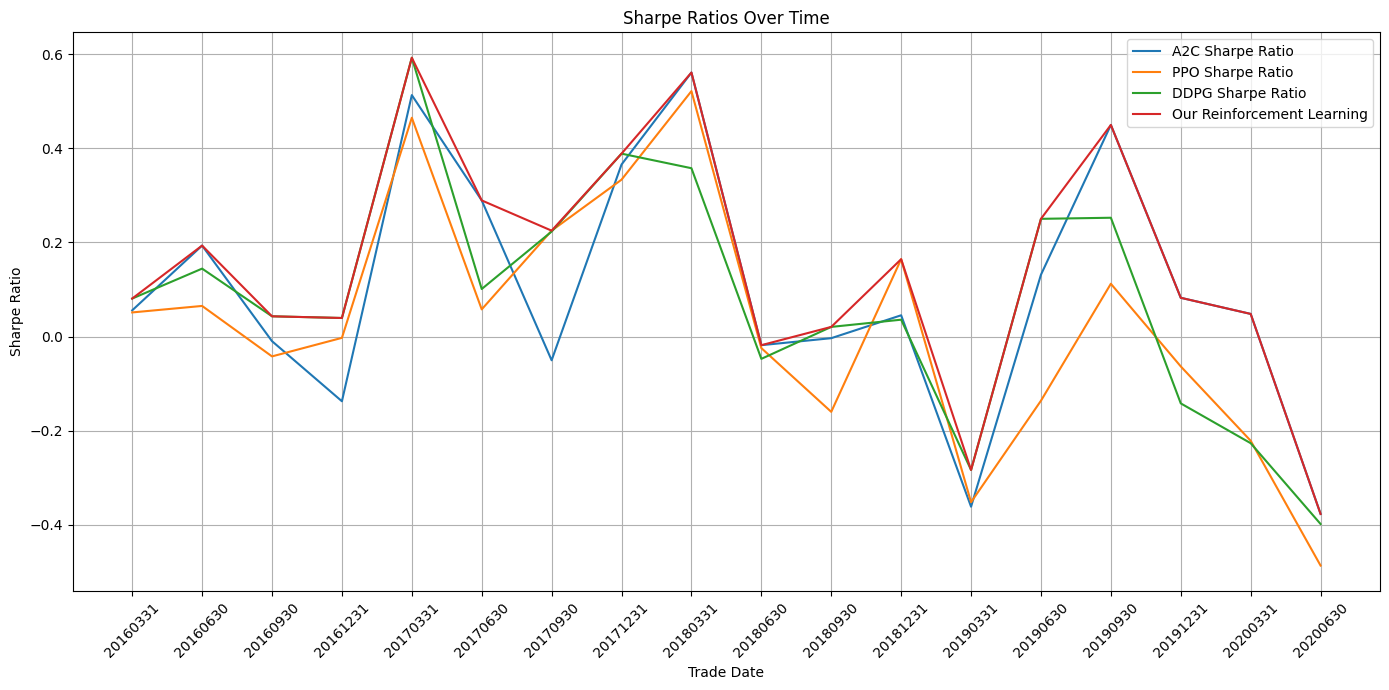

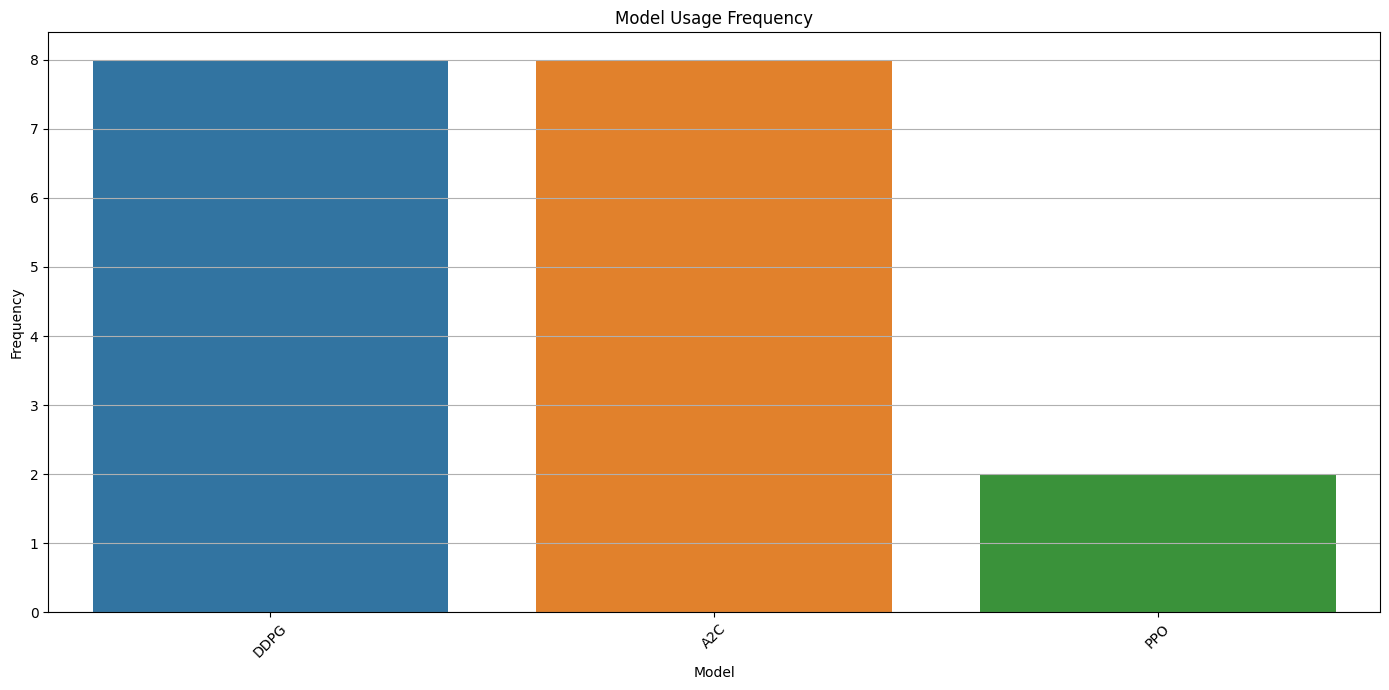

In [74]:
import seaborn as sns
def plot_sharpe_ratios(a2c_sharpe_list, ppo_sharpe_list, ddpg_sharpe_list, unique_trade_dates):
    plt.figure(figsize=(14, 7))
    plt.plot(unique_trade_dates[1:], a2c_sharpe_list, label='A2C Sharpe Ratio')
    plt.plot(unique_trade_dates[1:], ppo_sharpe_list, label='PPO Sharpe Ratio')
    plt.plot(unique_trade_dates[1:], ddpg_sharpe_list, label='DDPG Sharpe Ratio')
    plt.plot(unique_trade_dates[1:], max_values,label='Our Reinforcement Learning')
    plt.xlabel('Trade Date')
    plt.ylabel('Sharpe Ratio')
    plt.xticks(rotation=45)
    plt.title('Sharpe Ratios Over Time')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()  
    #plt.savefig('Sharpe_Ratios_Over_Time.png')  
    plt.show()

def plot_model_usage(model_use, unique_trade_dates):
    plt.figure(figsize=(14, 7))
    sns.countplot(x=model_use)
    plt.title('Model Usage Frequency')
    plt.xlabel('Model')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()  
    #plt.savefig('Model_Usage_Frequency.png')
    plt.show()

plot_sharpe_ratios(a2c_sharpe_list, ppo_sharpe_list, ddpg_sharpe_list, unique_trade_dates)
plot_model_usage(model_use, unique_trade_dates)

In [75]:
from tabulate import tabulate

data = {
    "Last Day of Test periods":unique_trade_dates[1:],
    "A2C Sharpe Ratio": a2c_sharpe_list,
    "PPO Sharpe Ratio": ppo_sharpe_list,
    "DDPG Sharpe Ratio": ddpg_sharpe_list,
    "Max Sharpe Ratio": max_values
}

df = pd.DataFrame(data)
df

,Last Day of Test periods,A2C Sharpe Ratio,PPO Sharpe Ratio,DDPG Sharpe Ratio,Max Sharpe Ratio
0,20160331,0.055631,0.051201,0.080692,0.080692
1,20160630,0.193279,0.065003,0.144322,0.193279
2,20160930,-0.009849,-0.042231,0.042984,0.042984
3,20161231,-0.137557,-0.002818,0.039389,0.039389
4,20170331,0.513065,0.464893,0.592477,0.592477
5,20170630,0.289241,0.057719,0.100990,0.289241
6,20170930,-0.050460,0.224962,0.223055,0.224962
7,20171231,0.365556,0.333339,0.388643,0.388643
8,20180331,0.561011,0.521494,0.357689,0.561011
9,20180630,-0.018381,-0.024556,-0.047443,-0.018381
